# Predicting Wildfire Risk in California
## Team Members:

Josh Hong - johong@csumb.edu

Jamal Ahmed - jaahmed@csumb.edu

Krishna Tagdiwala - ktagdiwala@csumb.edu

James Mondragon - jaimondragon@csumb.edu



## Introduction
Our project aims to build a machine learning tool to predict the likelihood and severity of wildfires in the contiguous US based on historical wildfire data:

* A binary classification to indicate whether a wildfire, if it occurs, is likely to be "large" (burns over 100 acres).

* Estimate the size of the given fire

* Predict the cause of a given fire (human-made or natural)



## Dataset Description
We are currently using the 1.88 Million US Wildfire dataset: [1.88 Million US Wildfires (1992-2015)](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires)

Source: U.S. federal, state, and local fire organizations
Fields include: fire size, discovery date, location, cause, and fire type.



# Predictor Features
Features we plan to use
* DISCOVERY_DATE (converted to month and day of year)
* CONT_DATE (converted to month and day of year)
* LATITUDE, LONGITUDE
* STAT_CAUSE_DESCR (fire cause)
* FIRE_SIZE
* FIRE_SIZE_CLASS

# Preprocessing & Cleaning

In [ ]:
#Code for pre processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
from google.colab import files
#ML Libaries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils import resample

Load and process datasets

In [ ]:
# Load selected columns from the 1.88 Million US Wildfires SQLite dataset
sqlite_file = "FPA_FOD_20170508.sqlite"

# query = """
# SELECT DISCOVERY_DATE, CONT_DATE, LATITUDE, LONGITUDE, STAT_CAUSE_DESCR, FIRE_SIZE, FIRE_SIZE_CLASS
# FROM Fires
# """
query = """
SELECT *
FROM Fires
"""

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rtatman/188-million-us-wildfires",
    sqlite_file,
    sql_query=query
)

# Convert Julian date to datetime format
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'], origin='julian', unit='D')
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'], origin='julian', unit='D')
df['MONTH'] = df['DISCOVERY_DATE'].dt.month

/tmp/ipython-input-3-2231017430.py:13: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
# Drop records of wildfires outside of the contiguous US
df = df[(df['LATITUDE']>25) & (df['LATITUDE']<50) & (df['LONGITUDE']>-130)]

In [ ]:
# Drop columns that have >=60% null values
keep_cols = df.isnull().sum()/len(df) < 0.6
df = df.loc[:,keep_cols]
# print(df.isnull().sum())

In [ ]:
# Classifies a fire as a "large fire" if it burned more than 100 acres
df['Large_Fire'] = (df['FIRE_SIZE'] > 10).astype(int)

# Assigns each size class to a number
size_class_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['FIRE_SIZE_CLASS_ENC'] = df['FIRE_SIZE_CLASS'].map(size_class_map)

#Simplify STAT_CAUSE_DESCR into binary: Human vs Natural
human_causes = [
    'Arson', 'Campfire', 'Children', 'Debris Burning', 'Equipment Use',
    'Fireworks', 'Powerline', 'Railroad', 'Smoking', 'Structure'
]
df['CAUSE_HUMAN'] = df['STAT_CAUSE_DESCR'].apply(
    lambda x: x in human_causes
)

#Exploration & Visualization

## Data Previews

In [ ]:
# Preview the first 20 rows of data
df.head(20)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,Large_Fire,FIRE_SIZE_CLASS_ENC,CAUSE_HUMAN,cont_days,FIRE_SIZE_ZSCALED,FIRE_SIZE_UISCALED,cont_days_ZSCALED,cont_days_UISCALED,FIRE_SIZE_LOGSCALED,cont_days_LOGSCALED
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,0,1,False,0.0,-0.030564,1.791299e-07,-0.074066,0.000000,0.095310,0.000000
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,0.0,-0.030485,4.478516e-07,-0.074066,0.000000,0.223144,0.000000
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,True,0.0,-0.030564,1.791299e-07,-0.074066,0.000000,0.095310,0.000000
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,5.0,-0.030564,1.791299e-07,0.249528,0.001244,0.095310,1.791759
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,5.0,-0.030564,1.791299e-07,0.249528,0.001244,0.095310,1.791759
5,6,6,FS-1418849,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,1.0,-0.030564,1.791299e-07,-0.009347,0.000249,0.095310,0.693147
6,7,7,FS-1418851,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,1.0,-0.030564,1.791299e-07,-0.009347,0.000249,0.095310,0.693147
7,8,8,FS-1418854,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,0,2,True,0.0,-0.030198,1.433165e-06,-0.074066,0.000000,0.587787,0.000000
8,9,9,FS-1418856,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,0,2,True,0.0,-0.030093,1.791460e-06,-0.074066,0.000000,0.693147,0.000000
9,10,10,FS-1418859,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,0,1,False,1.0,-0.030564,1.791299e-07,-0.009347,0.000249,0.095310,0.693147


In [ ]:
# Preview information about columns and their dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1835360 entries, 0 to 1880464
Data columns (total 43 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   OBJECTID                    int64         
 1   FOD_ID                      int64         
 2   FPA_ID                      object        
 3   SOURCE_SYSTEM_TYPE          object        
 4   SOURCE_SYSTEM               object        
 5   NWCG_REPORTING_AGENCY       object        
 6   NWCG_REPORTING_UNIT_ID      object        
 7   NWCG_REPORTING_UNIT_NAME    object        
 8   SOURCE_REPORTING_UNIT       object        
 9   SOURCE_REPORTING_UNIT_NAME  object        
 10  LOCAL_INCIDENT_ID           object        
 11  FIRE_NAME                   object        
 12  FIRE_YEAR                   int64         
 13  DISCOVERY_DATE              datetime64[ns]
 14  DISCOVERY_DOY               int64         
 15  DISCOVERY_TIME              object        
 16  STAT_CAUSE_CODE        

In [ ]:
# Preview dataframe stats
df.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,FIRE_SIZE,LATITUDE,...,MONTH,Large_Fire,FIRE_SIZE_CLASS_ENC,cont_days,FIRE_SIZE_ZSCALED,FIRE_SIZE_UISCALED,cont_days_ZSCALED,cont_days_UISCALED,FIRE_SIZE_LOGSCALED,cont_days_LOGSCALED
count,1.835360e+06,1.835360e+06,1.835360e+06,1835360,1.835360e+06,1.835360e+06,979773,979773.000000,1.835360e+06,1.835360e+06,...,1.835360e+06,1.835360e+06,1.835360e+06,979773.000000,1.835360e+06,1.835360e+06,9.797730e+05,979773.000000,1.835360e+06,979773.000000
mean,9.272982e+05,5.180579e+07,2.003666e+03,2004-02-12 20:42:02.730364160,1.654719e+02,5.864150e+00,2004-08-20 06:41:54.006816384,172.567469,5.857581e+01,3.690787e+01,...,5.954641e+00,1.275227e-01,1.839833e+00,1.144429,1.732649e-17,1.049373e-04,-5.801693e-19,0.000285,1.075661e+00,0.218048
min,1.000000e+00,1.000000e+00,1.992000e+03,1992-01-01 00:00:00,1.000000e+00,1.000000e+00,1992-01-01 00:00:00,1.000000,1.000000e-05,2.512150e+01,...,1.000000e+00,0.000000e+00,1.000000e+00,0.000000,-3.061589e-02,0.000000e+00,-7.406619e-02,0.000000,9.999950e-06,0.000000
25%,4.665018e+05,5.016688e+05,1.998000e+03,1998-08-30 00:00:00,9.000000e+01,3.000000e+00,1997-09-14 00:00:00,102.000000,1.000000e-01,3.295530e+01,...,3.000000e+00,0.000000e+00,1.000000e+00,0.000000,-3.056363e-02,1.791299e-07,-7.406619e-02,0.000000,9.531018e-02,0.000000
50%,9.258185e+05,1.053202e+06,2.004000e+03,2004-05-04 00:00:00,1.650000e+02,5.000000e+00,2005-04-04 00:00:00,181.000000,1.000000e+00,3.552330e+01,...,6.000000e+00,0.000000e+00,2.000000e+00,0.000000,-3.009323e-02,1.791460e-06,-7.406619e-02,0.000000,6.931472e-01,0.000000
75%,1.387240e+06,1.908303e+07,2.009000e+03,2009-07-24 00:00:00,2.310000e+02,9.000000e+00,2011-07-11 00:00:00,232.000000,3.400000e+00,4.081300e+01,...,8.000000e+00,0.000000e+00,2.000000e+00,0.000000,-2.883882e-02,6.091007e-06,-7.406619e-02,0.000000,1.481605e+00,0.000000
max,1.880465e+06,3.003484e+08,2.015000e+03,2015-12-31 00:00:00,3.660000e+02,1.300000e+01,2016-01-04 00:00:00,366.000000,5.581983e+05,4.934336e+01,...,1.200000e+01,1.000000e+00,7.000000e+00,4018.000000,2.917237e+02,1.000000e+00,2.599664e+02,1.000000,1.323247e+01,8.298788
std,5.361787e+05,9.915287e+07,6.695406e+00,NaN,9.003151e+01,3.385541e+00,NaN,84.574197,1.913248e+03,5.315128e+00,...,2.954831e+00,3.335576e-01,8.250377e-01,15.451440,1.000000e+00,3.427542e-03,1.000000e+00,0.003846,1.332574e+00,0.595464


## Heatmap

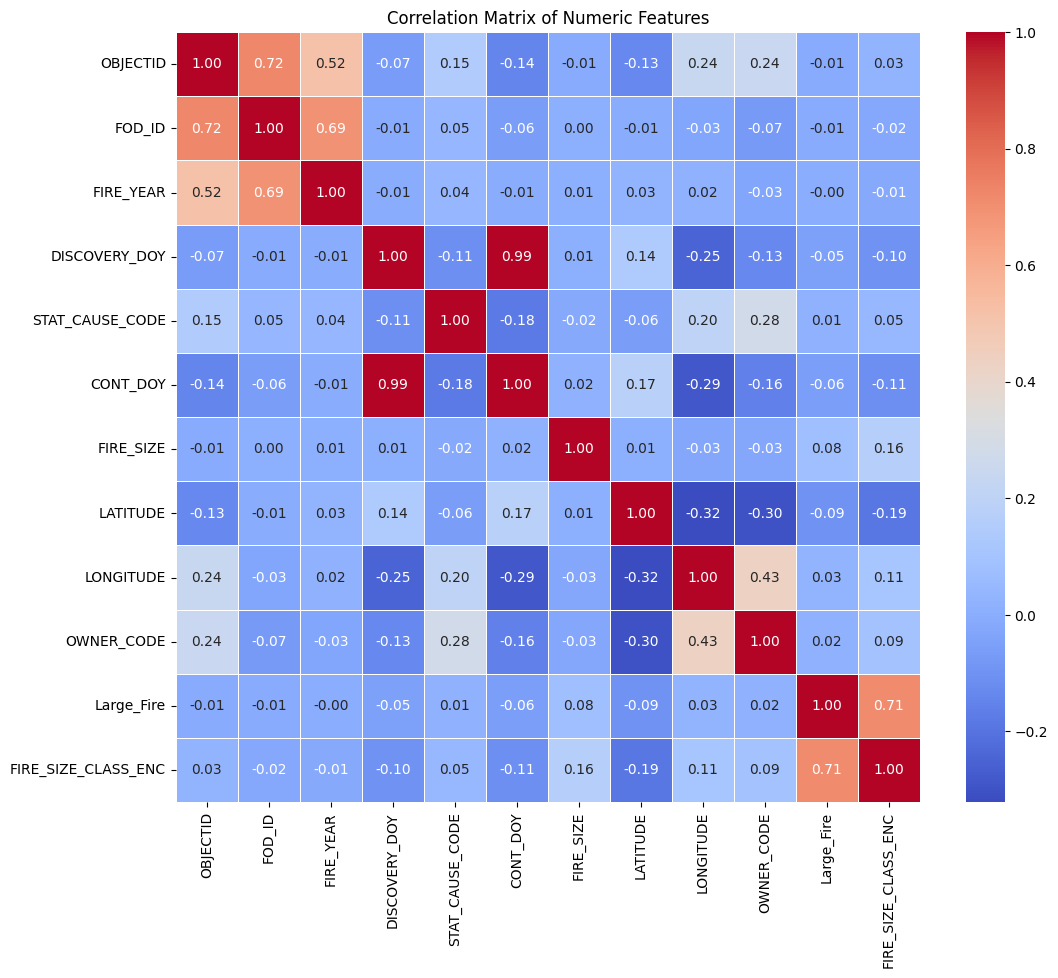

In [ ]:
# Create a heatmap to see which columns are most correlated
numeric_cols = df.select_dtypes(include=['float64', 'int64']).copy()

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## Graphs

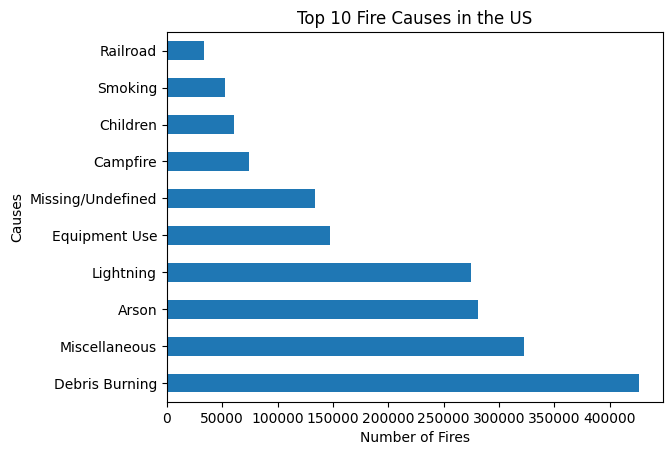

In [ ]:
# Graph the top 10 fire causes
df['STAT_CAUSE_DESCR'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Fire Causes in the US')
plt.xlabel('Number of Fires')
plt.ylabel('Causes')
plt.show()

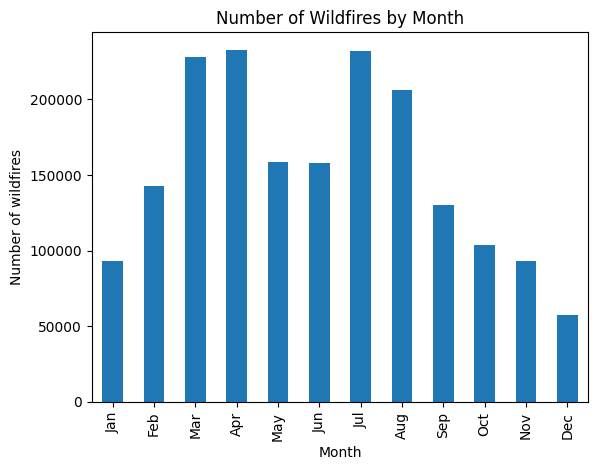

In [ ]:
# Graph wildfires by month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['MONTH'].value_counts().sort_index().plot(kind='bar')
plt.xticks(ticks=range(0,12), labels=month_names)

plt.title('Number of Wildfires by Month')
plt.xlabel('Month')
plt.ylabel('Number of wildfires')
plt.show()

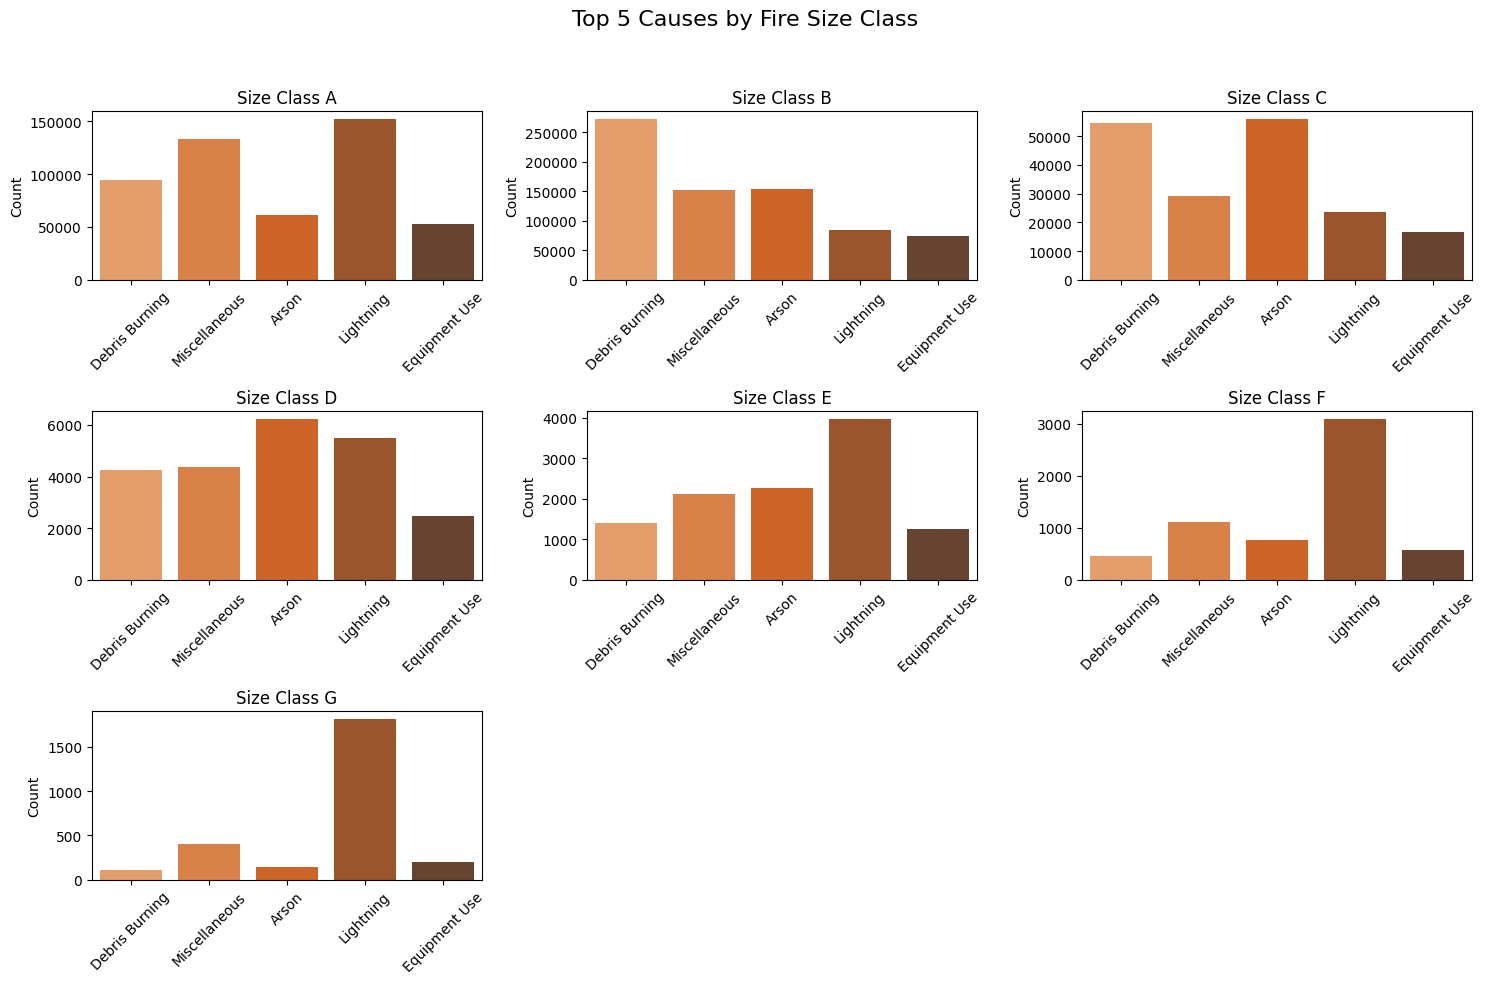

In [ ]:
# Plots the number of wildfires grouped by class, then cause
subset = df[df['STAT_CAUSE_DESCR'].notnull()]
top5 = subset['STAT_CAUSE_DESCR'].value_counts().head(5).index

df2 = df.copy()
df2 = df2[df2['STAT_CAUSE_DESCR'].isin(top5) & df2['FIRE_SIZE_CLASS'].notnull()]

# Fire size classes sorted by A-G
size_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Set up subplot grid
n_cols = 3
n_rows = int(np.ceil(len(size_classes) / n_cols))

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharey=True)
# axes = axes.flatten()

# Plot one subplot per fire size class
# for idx, size_class in enumerate(size_classes):
#     ax = axes[idx]
#     sub = df2[df2['FIRE_SIZE_CLASS'] == size_class]
#     counts = sub['STAT_CAUSE_DESCR'].value_counts().reindex(top5, fill_value=0)
#     counts_df = counts.reset_index()
#     counts_df.columns = ['STAT_CAUSE_DESCR', 'Count']

#     sns.barplot(
#         data=counts_df,
#         x='STAT_CAUSE_DESCR',
#         y='Count',
#         hue='STAT_CAUSE_DESCR',
#         palette='Blues_d',
#         ax=ax,
#         legend=False  # Hide legend per subplot
#     )
#     ax.set_title(f"Size Class {size_class}")
#     ax.set_xlabel("")
#     ax.set_ylabel("Count")
#     ax.tick_params(axis='x', rotation=45)

# # Hide any unused subplots
# for ax in axes[len(size_classes):]:
#     ax.set_visible(False)

# fig.suptitle("Top 5 Causes by Fire Size Class", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

# Set up subplot grid, without sharey, so all size class counts are easier to see.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Plot one subplot per fire size class
for idx, size_class in enumerate(size_classes):
    ax = axes[idx]
    sub = df2[df2['FIRE_SIZE_CLASS'] == size_class]
    counts = sub['STAT_CAUSE_DESCR'].value_counts().reindex(top5, fill_value=0)
    counts_df = counts.reset_index()
    counts_df.columns = ['STAT_CAUSE_DESCR', 'Count']

    sns.barplot(
        data=counts_df,
        x='STAT_CAUSE_DESCR',
        y='Count',
        hue='STAT_CAUSE_DESCR',
        palette='Oranges_d',
        ax=ax,
        legend=False  # Hide legend per subplot
    )
    ax.set_title(f"Size Class {size_class}")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for ax in axes[len(size_classes):]:
    ax.set_visible(False)

fig.suptitle("Top 5 Causes by Fire Size Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

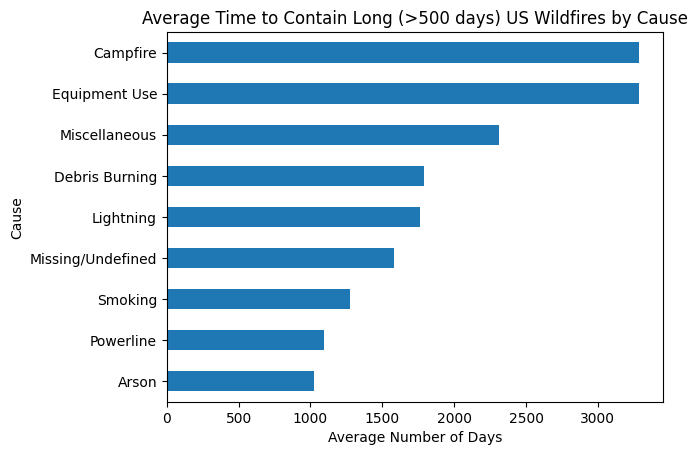

In [ ]:
# Graph the average number of days taken to contain long wildfires by cause
df['cont_days'] = (pd.to_datetime(df['CONT_DATE']) - pd.to_datetime(df['DISCOVERY_DATE'])).dt.days

df[df['cont_days']>500].groupby('STAT_CAUSE_DESCR')['cont_days'].mean().sort_values(ascending=True).plot(kind='barh')

plt.title('Average Time to Contain Long (>500 days) US Wildfires by Cause')
plt.xlabel('Average Number of Days')
plt.ylabel('Cause')
plt.show()

## Plots

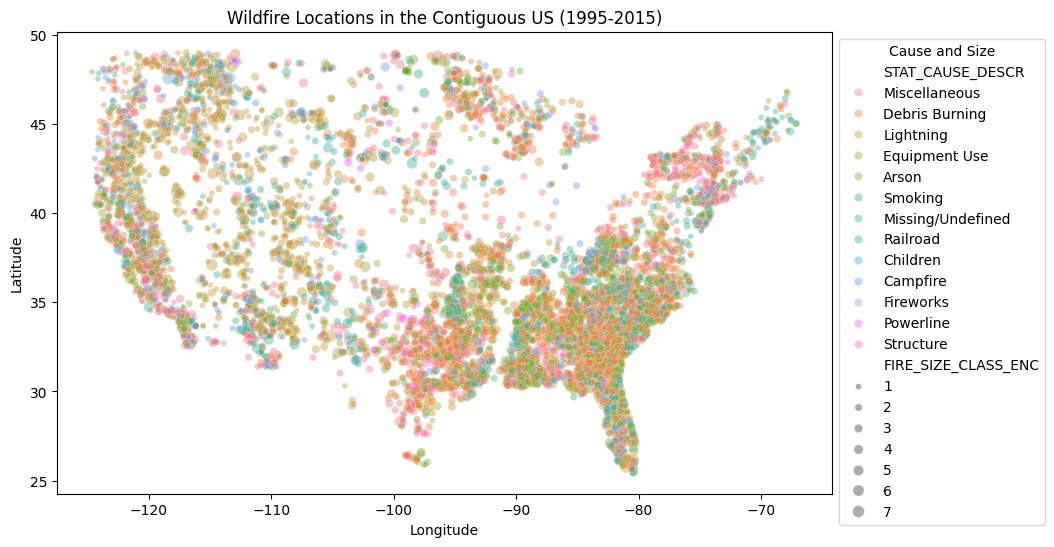

In [ ]:
# Plot wildfire Locations on a map
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(10000, random_state=42), x='LONGITUDE', y='LATITUDE', hue='STAT_CAUSE_DESCR', size="FIRE_SIZE_CLASS_ENC", alpha=0.4, legend=True)
plt.title("Wildfire Locations in the Contiguous US (1995-2015)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(bbox_to_anchor=(1, 1), title='Cause and Size')
plt.show()

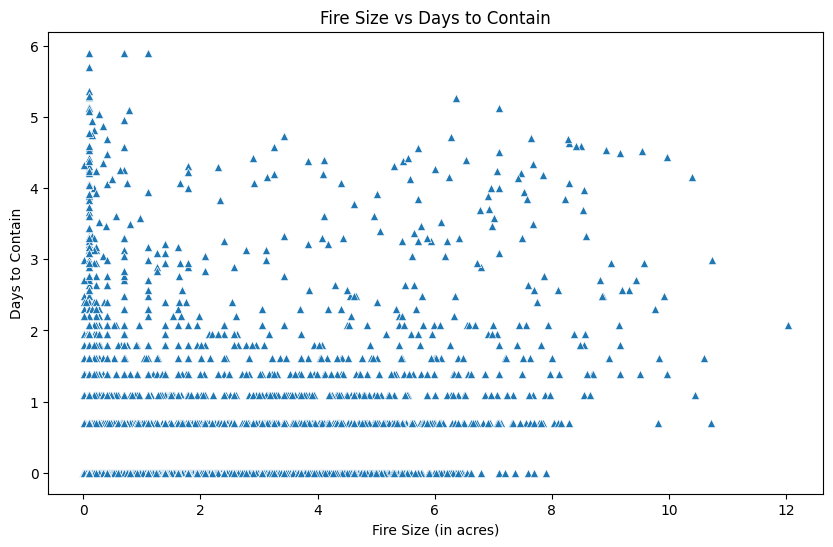

In [ ]:
# Plot fire size vs days to contain
plt.figure(figsize=(10, 6))

# Scaled using zscore normalization
df['FIRE_SIZE_ZSCALED'] = (df['FIRE_SIZE']-df['FIRE_SIZE'].mean())/df['FIRE_SIZE'].std()
df['FIRE_SIZE_UISCALED'] = (df['FIRE_SIZE'] - df['FIRE_SIZE'].min())/(df['FIRE_SIZE'].max()-df['FIRE_SIZE'].min())

# Scaled using unit-interval normalization
df['cont_days_ZSCALED'] = (df['cont_days']-df['cont_days'].mean())/df['cont_days'].std()
df['cont_days_UISCALED'] = (df['cont_days'] - df['cont_days'].min())/(df['cont_days'].max()-df['cont_days'].min())

# Scaled using logarithmic scaling
# Adding 1 to handle potential zero values, as log(0) is undefined.
df['FIRE_SIZE_LOGSCALED'] = np.log(df['FIRE_SIZE'] + 1)
df['cont_days_LOGSCALED'] = np.log(df['cont_days'] + 1)

sns.scatterplot(data=df.sample(n=30000, random_state=42), x='FIRE_SIZE_LOGSCALED', y='cont_days_LOGSCALED', marker='^')
plt.title("Fire Size vs Days to Contain")
plt.xlabel("Fire Size (in acres)")
plt.ylabel("Days to Contain")
plt.show()

# NOTE: Not much correlation between fire size and days to contain

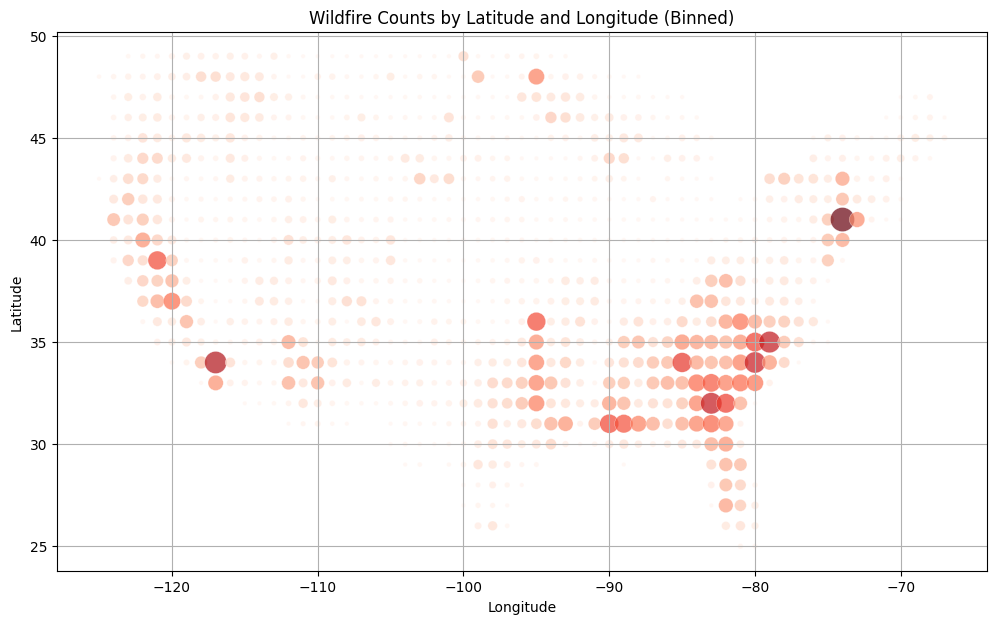

In [ ]:
# Plot wildfire counts by latitude/longitude
df_counts = df.copy()
bin_size = 1
df_counts['LAT_BIN'] = (df_counts['LATITUDE'] / bin_size).round() * bin_size
df_counts['LON_BIN'] = (df_counts['LONGITUDE'] / bin_size).round() * bin_size

# Count number of fires per rounded location
fire_counts = df_counts.groupby(['LAT_BIN', 'LON_BIN']).size().reset_index(name='FIRE_COUNT')

# Plot: point size = number of fires
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=fire_counts,
    x='LON_BIN',
    y='LAT_BIN',
    size='FIRE_COUNT',
    sizes=(10, 300),   # adjust range for visibility
    hue='FIRE_COUNT',
    palette='Reds',
    alpha=0.7,
    legend=False
)
plt.title("Wildfire Counts by Latitude and Longitude (Binned)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
# NOT USING DROUGHT DATASET
# # Elevation Distribution by Fire Cause (Top 5)

# # Join fire and drought data by closest lat/lon
# drought_coords = df_drought[['lat', 'lon']].values
# fire_coords = df[['LATITUDE', 'LONGITUDE']].dropna().values

# # Fit nearest neighbor model
# nn = NearestNeighbors(n_neighbors=1)
# nn.fit(drought_coords)

# # Get indices of nearest drought point for each fire
# distances, indices = nn.kneighbors(fire_coords)

# # Join datasets
# matched_drought = df_drought.iloc[indices.flatten()].reset_index(drop=True)
# fires_with_drought = df.iloc[:len(matched_drought)].reset_index(drop=True)
# fires_with_drought = pd.concat([fires_with_drought, matched_drought], axis=1)

# # Subset df with top 5 causes
# top_causes = fires_with_drought['STAT_CAUSE_DESCR'].value_counts().nlargest(5).index
# subset = fires_with_drought[fires_with_drought['STAT_CAUSE_DESCR'].isin(top_causes)]

# # Plot KDE
# top_causes = fires_with_drought['STAT_CAUSE_DESCR'].value_counts().nlargest(5).index
# subset = fires_with_drought[fires_with_drought['STAT_CAUSE_DESCR'].isin(top_causes)]

# sns.kdeplot(data=subset, x='elevation', hue='STAT_CAUSE_DESCR', fill=False, alpha=1)
# plt.title("Elevation Distribution by Fire Cause (Top 5)")
# plt.show()

# print(top_causes)


# Work on Machine Learning

## 1. Classify if a given wildfire is likely to be "large" or not

In [ ]:
# Prediction 1: Classify whether a wildfire occuring in a particular area is likely to be 'large' or not
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Select features and target
features = ['LATITUDE', 'LONGITUDE', 'MONTH']
X = df.sample(10000, random_state=42)[features]
y = df.sample(10000, random_state=42)['Large_Fire']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf.fit(X_train, y_train)

# Predict and Evaluate
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix:\n{cm}")

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1740
           1       0.29      0.11      0.16       260

    accuracy                           0.85      2000
   macro avg       0.58      0.53      0.54      2000
weighted avg       0.80      0.85      0.82      2000

Confusion Matrix:
[[1672   68]
 [ 232   28]]


## 2. Predict the Size of a Wildfire

In [ ]:
# Prediction 2: Predicts the size of a wildfire
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
# Selected features
selected_feature_names = ['LATITUDE', 'LONGITUDE', 'MONTH', 'FIRE_YEAR', 'FIRE_SIZE_CLASS_ENC', 'CAUSE_HUMAN']

# Prepare the dataframe with selected features and drop NAs
df_reg = df.sample(100000, random_state=42).dropna(subset=selected_feature_names + ['FIRE_SIZE']).copy()

# Convert boolean 'CAUSE_HUMAN' to int
df_reg['CAUSE_HUMAN'] = df_reg['CAUSE_HUMAN'].astype(int)

# Prepare input features and target
X = df_reg[selected_feature_names].values
y = np.log1p(df_reg['FIRE_SIZE'].values)  # log(1 + FIRE_SIZE)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit RandomForestRegressor
reg = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42)
reg.fit(X_train, y_train)

# Predict and convert back to original scale
y_pred_log = reg.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculate RMSE
rmse = np.sqrt(((y_pred - y_test_original) ** 2).mean())
print('RMSE: {:.2f}'.format(rmse))

RMSE: 947.35


In [ ]:
results_df = pd.DataFrame({
    'Predicted': y_pred,
    'Actual': y_test_original,
})

results_df['Label'] = np.where(results_df['Predicted'] > 100, 'Large Fire', 'Small Fire')

# Show example of predictions
print("Examples: Small Fire Predictions")
for _, row in results_df[results_df['Label'] == 'Small Fire'].head(5).iterrows():
    print('Predicted: {:.1f} acres ({}) | Actual: {:.1f} acres'.format(
        row['Predicted'], row['Label'], row['Actual']
    ))

print("\nExamples: Large Fire Predictions")
# Show 5 Large Fire predictions
for _, row in results_df[results_df['Label'] == 'Large Fire'].head(5).iterrows():
    print('Predicted: {:.1f} acres ({}) | Actual: {:.1f} acres'.format(
        row['Predicted'], row['Label'], row['Actual']
    ))

Examples: Small Fire Predictions
Predicted: 1.8 acres (Small Fire) | Actual: 1.0 acres
Predicted: 0.1 acres (Small Fire) | Actual: 0.1 acres
Predicted: 1.3 acres (Small Fire) | Actual: 2.0 acres
Predicted: 1.5 acres (Small Fire) | Actual: 3.5 acres
Predicted: 0.1 acres (Small Fire) | Actual: 0.1 acres

Examples: Large Fire Predictions
Predicted: 1950.8 acres (Large Fire) | Actual: 1162.0 acres
Predicted: 154.3 acres (Large Fire) | Actual: 220.0 acres
Predicted: 21989.1 acres (Large Fire) | Actual: 12000.0 acres
Predicted: 156.1 acres (Large Fire) | Actual: 104.0 acres
Predicted: 165.3 acres (Large Fire) | Actual: 150.0 acres


## 3. Determine if fire is man made

In [ ]:
# Prediction 3: Classify a wildfire as 'human-made' or 'naturally caused.
features = [
    'LATITUDE', 'LONGITUDE', 'MONTH',
    'DISCOVERY_DOY',
    'OWNER_CODE',
    'STATE',
    'FIRE_YEAR',
    'NWCG_REPORTING_AGENCY',
    'FIRE_SIZE_CLASS_ENC',
]

categorical_cols = ['OWNER_CODE', 'STATE', 'NWCG_REPORTING_AGENCY']

# Sample data
df_sample = df.sample(100000, random_state=42)
X = df_sample[features]
y = df_sample['CAUSE_HUMAN']

# One hot encode categorical columns
X = pd.get_dummies(X, columns=categorical_cols)

# Split after encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(
    n_estimators=20,
    max_depth=8,
    min_samples_leaf=10,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

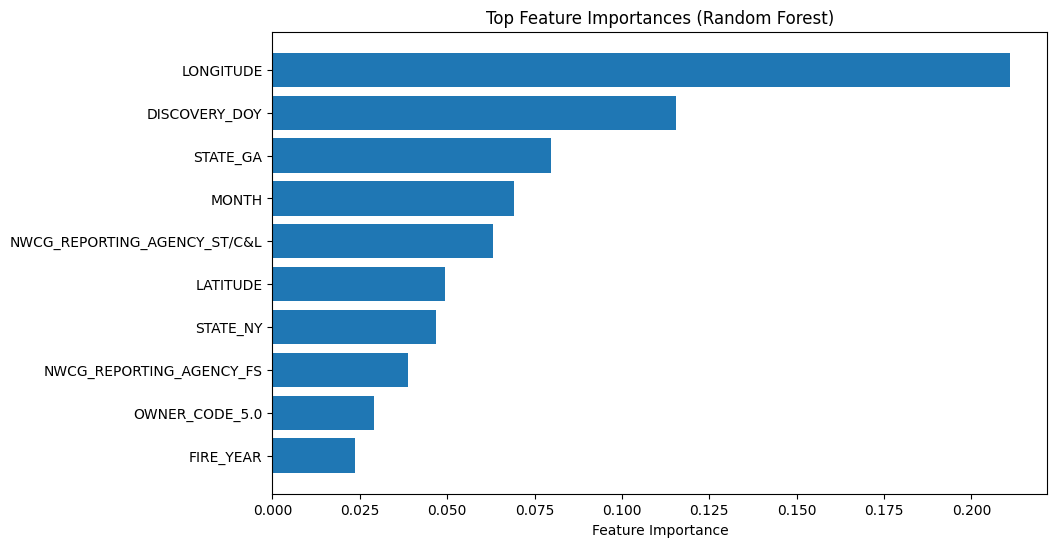

In [ ]:
importances = clf.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances (Random Forest)')
plt.show()

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.71995
              precision    recall  f1-score   support

       False       0.65      0.64      0.65      8032
        True       0.76      0.77      0.77     11968

    accuracy                           0.72     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.72      0.72      0.72     20000

Confusion Matrix:
[[5137 2895]
 [2706 9262]]
